In [ ]:

# ref
# X https://github.com/altosaar/variational-autoencoder/blob/master/train_variational_autoencoder_tensorflow.py
# X https://github.com/kvfrans/variational-autoencoder

# Good 
# https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

# Best toturial
# https://arxiv.org/pdf/1606.05908.pdf

# implementation
# Offical
# https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7

# https://danijar.com/building-variational-auto-encoders-in-tensorflow/
# https://docs.google.com/presentation/d/1VSNlkGcR-b39tMcuREjzZdhYOPvoZudpcbuNlf5hOIM/edit#slide=id.g30fdd2f6e9_0_72


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# compress dim by using tSNE
from sklearn.manifold import TSNE
plt.style.use('default')

In [39]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 13s 1us/step


In [43]:
def display_digit(image, label):
    plt.title('Label: %d' % label)
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

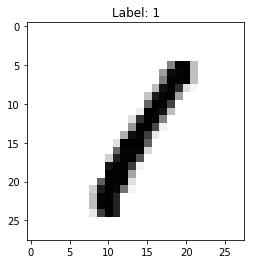

In [49]:
display_digit(x_train[3].reshape([28,28]), y_train[3])

In [23]:
tfd = tf.contrib.distributions

In [29]:
code_size = 16
hidden_units = [
    128,
    128,
]

In [30]:
def make_encoder(data):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, hidden_units[0], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[1], tf.nn.relu)
  mean = tf.layers.dense(x, code_size)
  stddev = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(mean, stddev)

In [31]:
def make_prior():
  mean = tf.zeros(code_size)
  stddev = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(mean, stddev)

In [32]:
def make_decoder(code, data_shape=[28, 28]):
  x = code
  x = tf.layers.dense(x, hidden_units[0], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[1], tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)

In [33]:
images = tf.placeholder(tf.float32, [None, 28, 28])
prior = make_prior()
posterior = make_encoder(images)
dist = make_decoder(posterior.sample())

